In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import gpytorch
from gpytorch import kernels, likelihoods
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xarray as xr
import regionmask
import tqdm
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'text.usetex': False,
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)


base_dir = os.path.join(os.getcwd(), '..')
sys.path.append(base_dir)

from src.torchFaIR import FaIR
from src.preprocessing import get_fair_params
from src.preprocessing import load_emissions_dataset, load_response_dataset
from src.structures import Scenario, ScenarioDataset, GridInducingScenario
from src.models import ThermalBoxesSVGP
import src.models.utils_svgp as svgp
import notebooks.utils_spatial as spatial

def colorbar(mappable):
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return

<IPython.core.display.Javascript object>

In [3]:
# Load scenarios xarrays
keys = ['historical', 'ssp245', 'ssp370']
inputs = {key: load_emissions_dataset(f'../data/inputs_{key}.nc') for key in keys}
outputs = {key: load_response_dataset(f'../data/outputs_{key}.nc') for key in keys}

# Load d and q maps
d_map = torch.from_numpy(np.load('./d_maps.npy')).double()
q_map = torch.from_numpy(np.load('./q_maps.npy')).double()
# d_map = d_map[:, 35:55, 110:130]
# q_map = q_map[:, 35:55, 110:130]
# d_map = d_map[:, :, 110:130]
# q_map = q_map[:, :, 110:130]

# Make spatial scenarios
spatial_hist_scenario = spatial.make_scenario(inputs, outputs, 'historical')
ssps = ['ssp245', 'ssp370']
spatial_scenarios = {'historical': spatial_hist_scenario}
for name in ssps:
    scenario = spatial.make_scenario(inputs, outputs, name, spatial_hist_scenario)
    spatial_scenarios[name] = scenario
    
scenario_dataset = ScenarioDataset(scenarios=[spatial_hist_scenario],
                                    hist_scenario=spatial_hist_scenario)

In [4]:
# Initi SVGP model
base_kwargs = get_fair_params()
forcing_pattern = np.ones((len(scenario.lat), len(scenario.lon)))
with torch.no_grad():
    FaIR_model = FaIR(**base_kwargs, forcing_pattern=forcing_pattern)
    for param in FaIR_model.parameters():
        param.requires_grad = False

inducing_scenario = GridInducingScenario(base_scenario=spatial_hist_scenario,
                                         n_inducing_times=10,
                                         n_inducing_lats=10,
                                         n_inducing_lons=10,
                                         d_map=d_map,
                                         q_map=q_map)
kernel = kernels.MaternKernel(nu=1.5, ard_num_dims=4, active_dims=[1, 2, 3, 4])
# kernel = kernels.ScaleKernel(base_kernel=kernel)
# kernel.outputscale = 10
likelihood = likelihoods.GaussianLikelihood()
model = ThermalBoxesSVGP(scenario_dataset=scenario_dataset,
                         inducing_scenario=inducing_scenario,
                         kernel=kernel,
                         likelihood=likelihood,
                         FaIR_model=FaIR_model,
                         q_map=q_map,
                         d_map=d_map)
model.likelihood.raw_noise.requires_grad = True
# with torch.no_grad():
#     model.variational_strategy.variational_distribution.covariance_matrix.mul_(5)

/home/bouabid/.pyenv/versions/sandbox/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
def compute_ell(qf, targets, batch_size, model):
    ηbar = qf.mean
    Σbar = qf.lazy_covariance_matrix
    
    # Compute ELL scaling term
    eps = torch.finfo(torch.float32).eps
    α = batch_size * torch.log(2 * np.pi * model.likelihood.noise + eps)
    
    # Compute ELL covariance term
    β = Σbar.diag().div(model.likelihood.noise).sum()
    
    # Compute ELL mean term
    γ = (targets.view(-1) - ηbar)**2
    γ = γ.div(model.likelihood.noise).sum()
    
    # Combine and return
    ell = -0.5 * torch.sum(α + β + γ)
    return ell, α, β, γ

In [6]:
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=scenario_dataset.tas.numel())

In [7]:
# Define optimizer and exact loglikelihood module
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# Extract useful variables
n_epochs = 3
batch_n_time = 10
batch_n_lat = 8
batch_n_lon = 8
batch_size = batch_n_time * batch_n_lat * batch_n_lon
n_samples = scenario_dataset.tas.numel()

# Set dataset shuffling seed
torch.random.manual_seed(5)

αs, βs, γs, ells, kls, losses = [], [], [], [], [], []

# Iterate over epochs
for epoch in tqdm.notebook.tqdm(range(n_epochs), desc='Epoch', total=n_epochs):
    epoch_ell, epoch_kl, epoch_loss = 0, 0, 0
    batch_bar = tqdm.notebook.tqdm(range(n_samples // batch_size), desc='Batch')
    for i in batch_bar:
        batch = model.sample_batch(batch_n_time, batch_n_lat, batch_n_lon)
        scenario, time_idx, lat_idx, lon_idx, targets = batch

        optimizer.zero_grad()

        qf = model(scenario, time_idx, lat_idx, lon_idx)
        ell, α, β, γ = compute_ell(qf, targets, batch_size, model)
        kl_divergence = model.variational_strategy.kl_divergence().mul(batch_size / n_samples)

        loss = (kl_divergence - ell) / batch_size
#         loss = -mll(qf, targets.flatten())
        loss.backward()
        optimizer.step()
        
        αs.append(α.detach().item())
        βs.append(β.detach().item())
        γs.append(γ.detach().item())
        ells.append(ell.detach().item())
        kls.append(kl_divergence.detach().item())
        losses.append(loss.detach().item())

        epoch_ell += ell.item()
        epoch_kl += kl_divergence.item()
        epoch_loss += loss.item()
        batch_bar.set_postfix_str(f"ELL {epoch_ell / (i + 1):e} | KL {epoch_kl / (i + 1):e} | Loss {epoch_loss / (i + 1):e}")

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Batch:   0%|          | 0/3564 [00:00<?, ?it/s]

KeyboardInterrupt: 

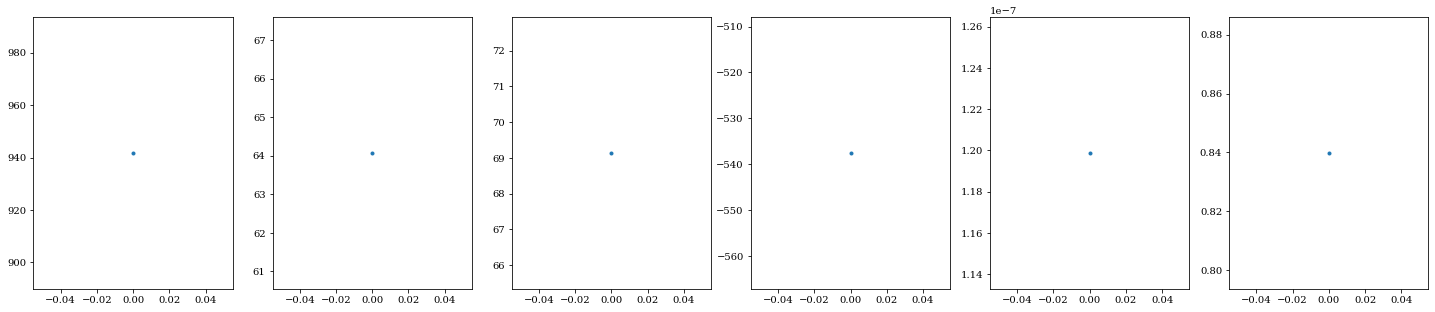

In [8]:
fig, ax = plt.subplots(1, 6, figsize=(25, 5))
ax[0].plot(αs, '--.')
ax[1].plot(βs, '--.')
ax[2].plot(γs, '--.')
ax[3].plot(ells, '--.')
ax[4].plot(kls, '--.')
ax[5].plot(losses, '--.')

In [54]:
# Something is awefully wrong in the computation of the posterior distribution

In [ ]:
scenario = spatial_scenarios['ssp245']
time_idx = torch.arange(10, 11)
lat_idx = torch.arange(10, 86)
lon_idx = torch.arange(10, 134)
μ = model._compute_mean(scenario)[time_idx][:, lat_idx][:, :, lon_idx]
# μ = model.train_means['historical'][time_idx][:, lat_idx][:, :, lon_idx]
gt = scenario.tas[time_idx][:, lat_idx][:, :, lon_idx]

with torch.no_grad():
    qf = model(scenario, time_idx, lat_idx, lon_idx)
    ηbar = qf.mean
#     Σbar = qf.lazy_covariance_matrix
#     stddev = torch.sqrt(Σbar.diag())
    stddev = torch.sqrt(qf.variance)
    ηbar = model.mu_targets + model.sigma_targets * ηbar
    mean_pred = ηbar.reshape(μ.shape) + μ

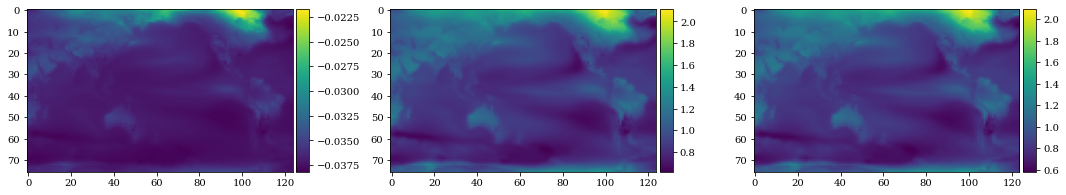

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
i = 0
colorbar(ax[0].imshow(ηbar.reshape(μ.shape)[i].numpy()[::-1]))
colorbar(ax[1].imshow(μ[i].numpy()[::-1]))
colorbar(ax[2].imshow(mean_pred[i].numpy()[::-1]))
plt.tight_layout()

tensor([0.0010, 0.0010, 0.0010,  ..., 0.0014, 0.0014, 0.0014])


ValueError: x and y can be no greater than 2D, but have shapes torch.Size([3]) and torch.Size([3, 20, 20])

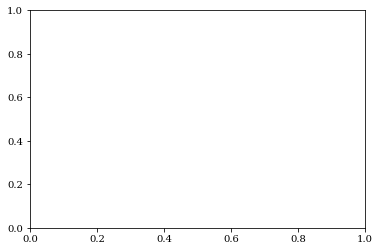

In [33]:
print(Σbar.diag())
plt.plot(time_idx, mean_pred.squeeze())
plt.fill_between(time_idx, mean_pred.squeeze() - stddev, mean_pred.squeeze() + stddev, alpha=0.5)
plt.plot(time_idx, gt.squeeze())
plt.plot(time_idx, torch.squeeze(qf.sample().reshape(μ.shape) + μ))

tensor(0.0010)


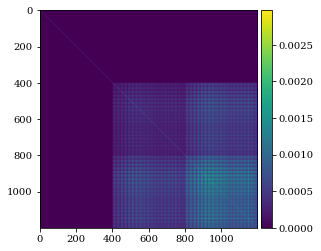

In [43]:
# foo = qf.covariance_matrix[:, 0].reshape(len(time_idx), len(lat_idx), len(lon_idx))
# foo = qf.mean.reshape(len(time_idx), len(lat_idx), len(lon_idx))
# colorbar(plt.imshow(foo[0]))
# foo = qf.covariance_matrix.reshape(1, 40, 40, 1, 40, 40)
print(Σbar.diag().min())
colorbar(plt.imshow(qf.covariance_matrix))

In [34]:
# with torch.no_grad():
#     model.variational_strategy.variational_distribution.covariance_matrix.mul_(5)

with torch.no_grad():
    Kxx, Kww, Kwx = model._compute_covariance(scenario, time_idx, lat_idx, lon_idx)
    η = model.variational_strategy.variational_distribution.mean
    Σ = model.variational_strategy.variational_distribution.covariance_matrix
    chol = torch.linalg.cholesky(Kww)
    Linv = chol.inverse()
    myηbar = Kwx.t() @ Linv.t() @ η
    I = torch.eye(len(Linv))
    myΣbar = Kxx + Kwx.t() @ Linv.t() @ (Σ - I) @ Linv @ Kwx

In [35]:
inducing_scenario

GridInducingScenario(historical, time=10, lat=2, lon=2)

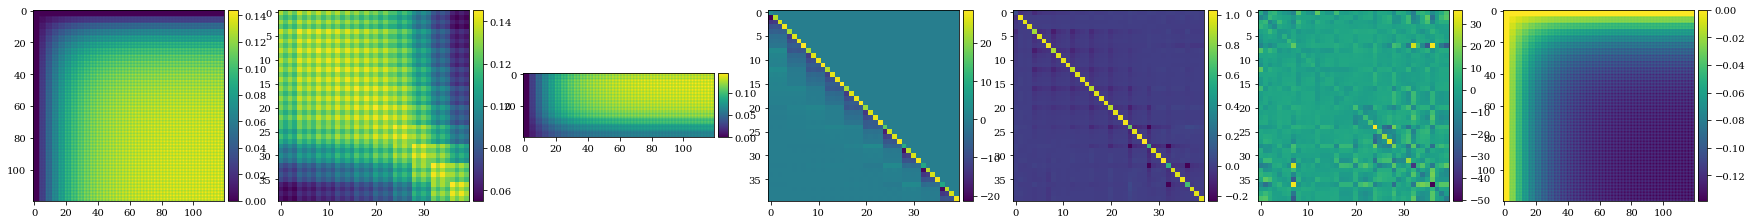

In [36]:
fig, ax = plt.subplots(1, 7, figsize=(5 * 6, 4))
colorbar(ax[0].imshow(Kxx))
colorbar(ax[1].imshow(Kww))
colorbar(ax[2].imshow(Kwx))
colorbar(ax[3].imshow(Linv))
colorbar(ax[4].imshow(Σ))
colorbar(ax[5].imshow(Linv.t() @ (Σ - I) @ Linv))
colorbar(ax[6].imshow(Kwx.t() @ Linv.t() @ (Σ - I) @ Linv @ Kwx))

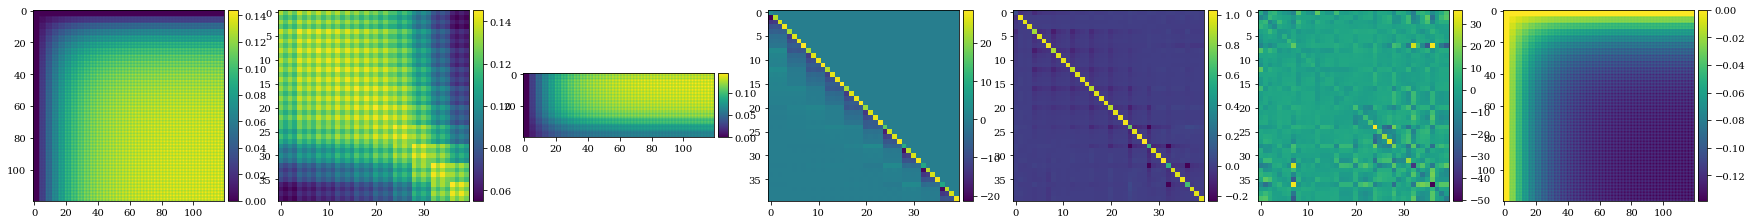

In [37]:
fig, ax = plt.subplots(1, 7, figsize=(5 * 6, 4))
colorbar(ax[0].imshow(Kxx))
colorbar(ax[1].imshow(Kww))
colorbar(ax[2].imshow(Kwx))
colorbar(ax[3].imshow(Linv))
colorbar(ax[4].imshow(Σ))
colorbar(ax[5].imshow(Linv.t() @ (Σ - I) @ Linv))
colorbar(ax[6].imshow(Kwx.t() @ Linv.t() @ (Σ - I) @ Linv @ Kwx))

In [132]:
3 * 3 * 18

162

In [130]:
Kxx.shape

torch.Size([162, 162])